# Initial Data Import and Pre Processing

Kaggle Import

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d rdxesss/covid19-segmentation
!unzip \*.zip && rm *.zip

ID's 

In [ ]:
!pip install q tensorflow==2.1.0
!pip install q keras==2.3.1
!pip install segmentation_models==1.0.1
!pip install h5py==2.10.0
import segmentation_models as sm

# keras==2.3.1
# tensorflow==2.1.0
# segmentation-models==1.0.1
# h5py==2.10.0

# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
# !pip install -U albumentations==0.3.0 --user
!pip install -U albumentations==0.2.3 --user 

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 421.8 MB 24 kB/s 
     |████████████████████████████████| 448 kB 68.3 MB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 
     |████████████████████████████████| 3.8 MB 50.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=535cf2c14bc987af0fb18b55488e3b5b247b2326a517b8c3dc1f47ec4fcb0cdb
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
     |████████████████████████████████| 64 kB 1.9 MB/s 
     |████████████████████████████████| 47.6 MB 30 kB/s 
     |████████████████████████████████| 631 kB 69.4 MB/s 
  Created wheel for albumentations: filename=albumentations-0.2.3-py3-none-any.whl size=40619 sha256=6f0f8880c648157301027379c0853a504e44e510a359ca2416d39225971494e5
  Stored in directory: /root/.cache/pip/wheels/54/7b/67/50aa66430489a1bad29ac8ebe0e31c58eafe5110a38e49b509
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654020 sha256=a11c0faf0ab9c8247aa3e14feb378849c6acef759b11fabf27be568b5ff02fc3
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built albumentations imgaug


Directory Load

In [ ]:
import os
patchsize = 256

# Training data
x_train_dir = '/content/datacovd19/train/images'
y_train_dir = '/content/datacovd19/train/masks'

# Validation data
x_valid_dir = '/content/datacovd19/val/images'
y_valid_dir = '/content/datacovd19/val/masks'


x_test_dir = '/content/datacovd19/test/images'
y_test_dir = '/content/datacovd19/test/masks'

print("Training and validation samples: ", len(os.listdir(x_train_dir)), len(os.listdir(x_valid_dir)), len(os.listdir(x_test_dir)))

Training and validation samples:  2840 680 500


In [ ]:
#Dataloader and utility functions
    
# Helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    
    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "black","red","blue"])

    
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap=map_name, norm=norm)
    plt.show()
    
    
# Helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

Data Loading and Pre Processing

In [ ]:
# Classes for data loading and preprocessing
class Dataset:
    """Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['RightLung', 'LeftLung', 'Disease', 'unlabelled']
   
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        
        # Sorted
        self.images_fps = sorted([os.path.join(images_dir, image_id) for image_id in self.ids])
        self.masks_fps = sorted([os.path.join(masks_dir, image_id) for image_id in self.ids])

        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls) for cls in classes] # cls used instead of cls.lower()

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # Read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = skimage.io.imread(self.images_fps[i])
        
        
        mask = cv2.imread(self.masks_fps[i], 0)
        #mask = skimage.io.imread(self.masks_fps[i])
        
        
        # Extract certain classes from mask
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # Add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # Apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [ ]:
import random
#Test the dataset class
# Load a random image from the images folder
image_fns = sorted(next(os.walk(x_train_dir))[2])
gt_fns = sorted(next(os.walk(y_train_dir))[2])
print(image_fns[:3], gt_fns[:3])

# Get random number
idx = random.randrange(len(image_fns))
print("Index: ", idx)

import skimage
from skimage import io
# Read image and mask
image = io.imread(os.path.join(x_train_dir, image_fns[idx]))
gt = io.imread(os.path.join(y_train_dir, gt_fns[idx]))

print(image.shape, gt.shape)

val1 = gt.flatten()
print("Ground truth classes: ", np.unique(val1))

['1.png', '10.png', '100.png'] ['1.png', '10.png', '100.png']
Index:  1873
(256, 256) (256, 256)
Ground truth classes:  [0 1 2]


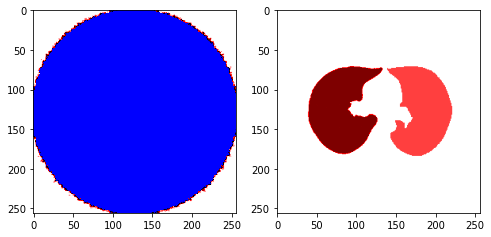

In [ ]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()


#####################################################
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        # newer version of tf/keras want batch to be in tuple rather than list
        return tuple(batch)
#########################################################

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # Transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


import matplotlib.colors
norm=plt.Normalize(0,4) # 5 classes including BG
map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "red","black","blue"])

f, axarr = plt.subplots(1,2, figsize=(8,8))

# idx = 94 all classes

axarr[0].imshow(image, cmap=map_name, norm=norm)
axarr[1].imshow(gt, cmap=map_name, norm=norm)

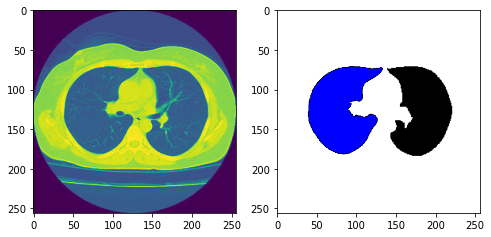

In [ ]:
import matplotlib.colors
import matplotlib.pyplot as plt
norm=plt.Normalize(0,3) # 4 classes including BG
map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","black","blue","red"])

f, axarr = plt.subplots(1,2, figsize=(8,8))

axarr[0].imshow(image)
axarr[1].imshow(gt, cmap =map_name, norm=norm)

(256, 256, 3) (256, 256, 4)


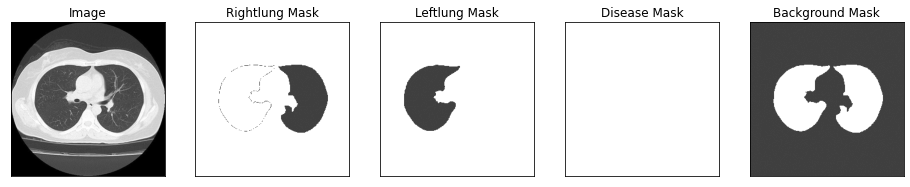

(256, 256, 3) (256, 256, 4)


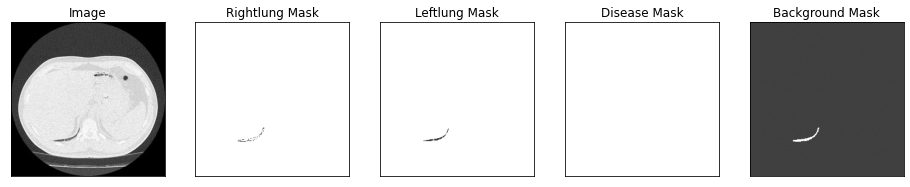

(256, 256, 3) (256, 256, 4)


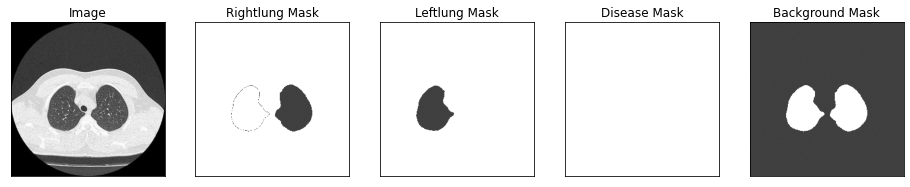

(256, 256, 3) (256, 256, 4)


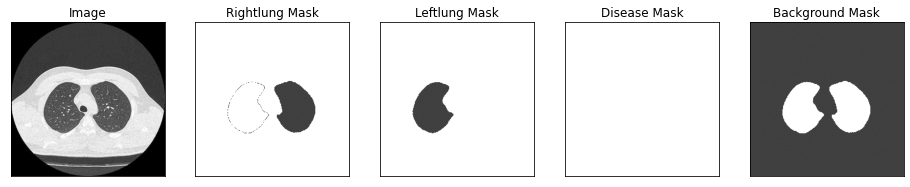

(256, 256, 3) (256, 256, 4)


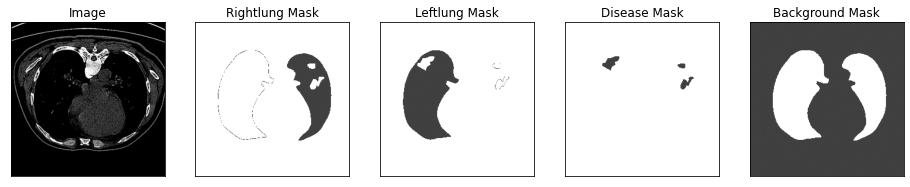

(256, 256, 3) (256, 256, 4)


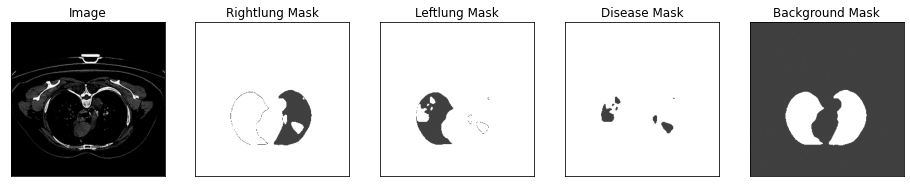

In [ ]:
med= ['RightLung', 'LeftLung', 'Disease']

dataset = Dataset(x_train_dir, y_train_dir, classes=med)
image, mask = dataset[idx] 

print(image.shape, mask.shape)
visualize(
    image=image, 
    RightLung_mask = mask[..., 1].squeeze(),
    LeftLung_mask = mask[..., 2].squeeze(),
    Disease_mask = mask[..., 3].squeeze(),
    background_mask = mask[..., 0].squeeze(),
)

med= ['RightLung', 'LeftLung', 'Disease']

dataset = Dataset(x_train_dir, y_train_dir, classes=med)

for i in range(5):
    
    image, mask = dataset[random.randrange(len(dataset))] # get some sample
    print(image.shape, mask.shape)
    
    visualize(
    image=image, 
    RightLung_mask = mask[..., 1].squeeze(),
    LeftLung_mask = mask[..., 2].squeeze(),
    Disease_mask = mask[..., 3].squeeze(),
    background_mask = mask[..., 0].squeeze(),
    )

Heavy Image Augmentation

In [ ]:
import albumentations as A

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.RandomCrop(height=patchsize, width=patchsize, always_apply=True), # patchsize instead of 320

        A.IAAAdditiveGaussianNoise(p=0.2),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 96"""
    test_transform = [
        A.PadIfNeeded(patchsize, patchsize)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        # A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

(256, 256, 3) (256, 256, 4)


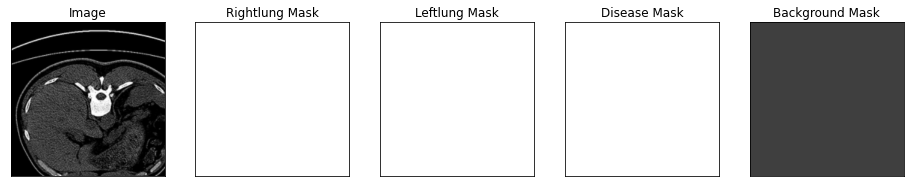

(256, 256, 3) (256, 256, 4)


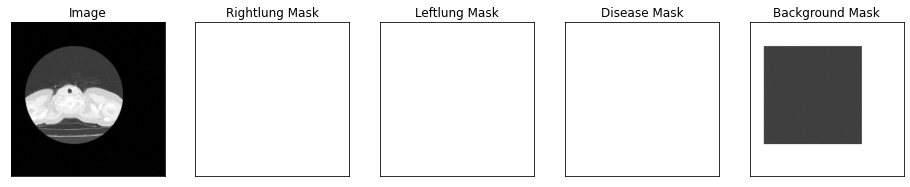

(256, 256, 3) (256, 256, 4)


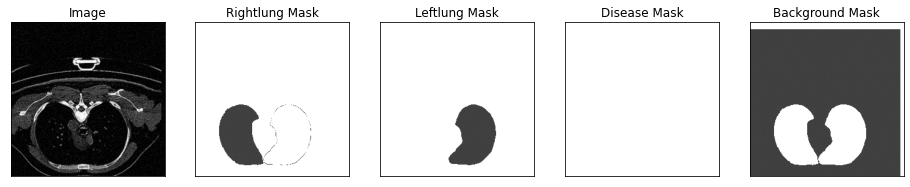

(256, 256, 3) (256, 256, 4)


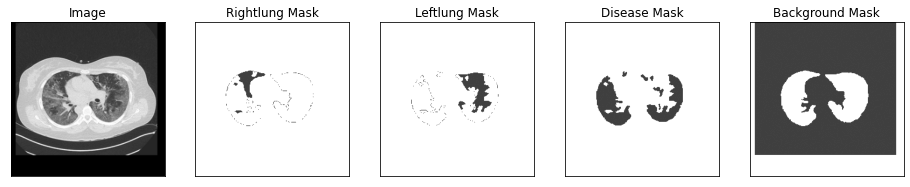

(256, 256, 3) (256, 256, 4)


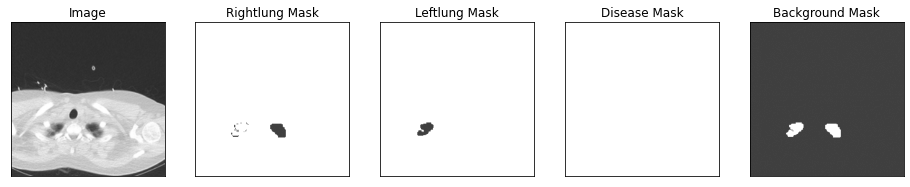

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir, classes=med, augmentation=get_training_augmentation())
for i in range(5):
    
    image, mask = dataset[random.randrange(len(dataset))] # get some sample
    print(image.shape, mask.shape)
    
    visualize(
    image=image, 
    RightLung_mask = mask[..., 1].squeeze(),
    LeftLung_mask = mask[..., 2].squeeze(),
    Disease_mask = mask[..., 3].squeeze(),
    background_mask = mask[..., 0].squeeze(),
    )

# FPN + EfficientnetB3

Model Creation

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`


BACKBONE = 'efficientnetb3'
BATCH_SIZE = 16
CLASSES = med
LR = 0.0001
EPOCHS = 25

preprocess_input = sm.get_preprocessing(BACKBONE)


# define network parameters
n_classes = 4 # case for binary and multiclass segmentation
activation = 'softmax' 

# #create model
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', input_shape = (256, 256, 3))



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3))
# I personally would chose (None, None, 3) for the input shape
#

44113920/44107200 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 40) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

Error check

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Zenodo MnC/fpn/models/fpn_efficientnetb3.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/Zenodo MnC/fpn/csv/fpn_efficientnetb3.csv', separator=",", append=True)
]

Training

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=25, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/25
177/177 [==============================] - 527s 3s/step - loss: 0.1603 - iou_score: 0.3084 - f1-score: 0.3791 - val_loss: 0.0719 - val_iou_score: 0.4665 - val_f1-score: 0.5088
Epoch 2/25
177/177 [==============================] - 468s 3s/step - loss: 0.1085 - iou_score: 0.4767 - f1-score: 0.5543 - val_loss: 0.0254 - val_iou_score: 0.6064 - val_f1-score: 0.6463
Epoch 3/25
177/177 [==============================] - 469s 3s/step - loss: 0.0913 - iou_score: 0.5606 - f1-score: 0.6323 - val_loss: 0.0208 - val_iou_score: 0.6198 - val_f1-score: 0.6590
Epoch 4/25
177/177 [==============================] - 467s 3s/step - loss: 0.0879 - iou_score: 0.6007 - f1-score: 0.6718 - val_loss: 0.0184 - val_iou_score: 0.6153 - val_f1-score: 0.6602
Epoch 5/25
177/177 [==============================] - 470s 3s/step - loss: 0.0841 - iou_score: 0.6218 - f1-score: 0.6898 - val_loss: 0.0194 - val_iou_score: 0.6497 - val_f1-score: 0.6940
Epoch 6/25
177/177 [==============================] - 471s 3s/ste

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Graphs

In [ ]:
fig, axs = plt.subplots(1, 6, figsize = (25, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy4 = history.history['f1-score']
validation_accuracy4 = history.history['val_f1-score']

training_accuracy5 = history.history['iou_score']
validation_accuracy5 = history.history['val_iou_score']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[4].plot(epoch_count, training_accuracy4, 'r--')
axs[4].plot(epoch_count, validation_accuracy4, 'b-')
axs[4].legend(['Training F1', 'Validation F1'])

axs[5].plot(epoch_count, training_accuracy5, 'r--')
axs[5].plot(epoch_count, validation_accuracy5, 'b-')
axs[5].legend(['Training IOU', 'Validation IOU'])

Testing

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=med, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=16, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('/content/drive/MyDrive/Zenodo MnC/fpn/models/fpn_efficientnetb3.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.018751
mean iou_score: 0.64814
mean f1-score: 0.70827


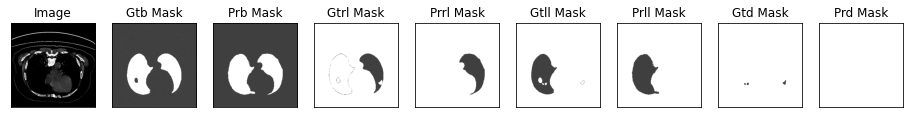

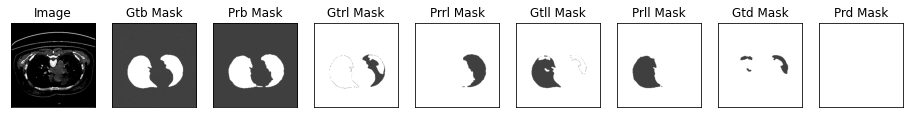

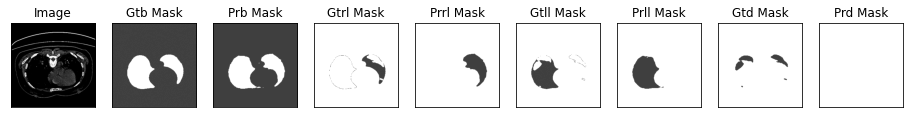

In [ ]:
n = 3
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gtB_mask=gt_mask[..., 0].squeeze(),
        prB_mask=pr_mask[..., 0].squeeze(),
        gtRL_mask=gt_mask[..., 1].squeeze(),
        prRL_mask=pr_mask[..., 1].squeeze(),
        gtLL_mask=gt_mask[..., 2].squeeze(),
        prLL_mask=pr_mask[..., 2].squeeze(),
        gtD_mask=gt_mask[..., 3].squeeze(),
        prD_mask=pr_mask[..., 3].squeeze(),
    )

ROC CURVE

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(K.flatten(test_data_y[..., i]), K.flatten(y_pred[..., i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

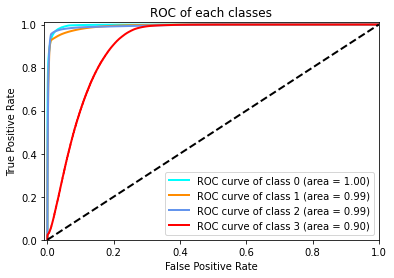

In [ ]:
lw = 2
colors = (['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of each classes')
plt.legend(loc="lower right")
plt.show()

# FPN + vgg19

Model Creation

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`


BACKBONE = 'vgg19'
BATCH_SIZE = 16
CLASSES = med
LR = 0.0001
EPOCHS = 20

preprocess_input = sm.get_preprocessing(BACKBONE)


# define network parameters
n_classes = 4 # case for binary and multiclass segmentation
activation = 'softmax' 

# #create model
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', input_shape = (256, 256, 3))



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3))
# I personally would chose (None, None, 3) for the input shape
#

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

Error check

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Zenodo MnC/fpn/models/fpn_vgg19.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/Zenodo MnC/fpn/csv/fpn_vgg19.csv', separator=",", append=True)
]

Training

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=20, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/20
177/177 [==============================] - 370s 2s/step - loss: 0.1559 - iou_score: 0.3346 - f1-score: 0.4097 - val_loss: 0.1179 - val_iou_score: 0.4904 - val_f1-score: 0.5287
Epoch 2/20
177/177 [==============================] - 353s 2s/step - loss: 0.1076 - iou_score: 0.4851 - f1-score: 0.5657 - val_loss: 0.0703 - val_iou_score: 0.5620 - val_f1-score: 0.6140
Epoch 3/20
177/177 [==============================] - 353s 2s/step - loss: 0.0927 - iou_score: 0.5879 - f1-score: 0.6557 - val_loss: 0.0279 - val_iou_score: 0.6447 - val_f1-score: 0.6894
Epoch 4/20
177/177 [==============================] - 352s 2s/step - loss: 0.0916 - iou_score: 0.5958 - f1-score: 0.6634 - val_loss: 0.0301 - val_iou_score: 0.6511 - val_f1-score: 0.6913
Epoch 5/20
177/177 [==============================] - 353s 2s/step - loss: 0.0834 - iou_score: 0.6382 - f1-score: 0.7010 - val_loss: 0.0261 - val_iou_score: 0.6703 - val_f1-score: 0.7118
Epoch 6/20
177/177 [==============================] - 353s 2s/ste

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.095948
mean iou_score: 0.72941
mean f1-score: 0.78882


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.017479
mean iou_score: 0.73039
mean f1-score: 0.77286


Graphs

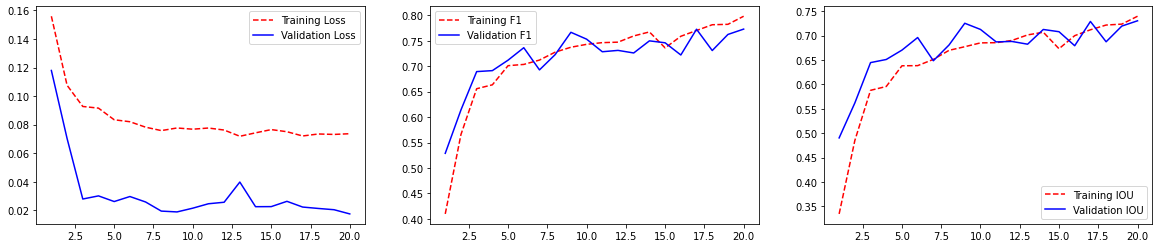

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy4 = history.history['f1-score']
validation_accuracy4 = history.history['val_f1-score']

training_accuracy5 = history.history['iou_score']
validation_accuracy5 = history.history['val_iou_score']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy4, 'r--')
axs[1].plot(epoch_count, validation_accuracy4, 'b-')
axs[1].legend(['Training F1', 'Validation F1'])

axs[2].plot(epoch_count, training_accuracy5, 'r--')
axs[2].plot(epoch_count, validation_accuracy5, 'b-')
axs[2].legend(['Training IOU', 'Validation IOU'])

Testing

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=med, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=16, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('/content/drive/MyDrive/Z Segmentation/Unet/Models/UnetEB00.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.018671
mean iou_score: 0.67858
mean f1-score: 0.73989


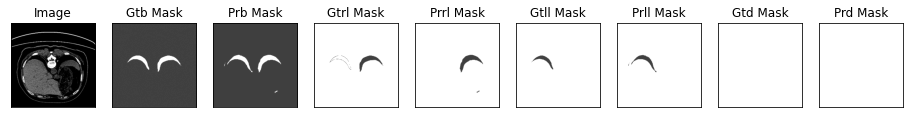

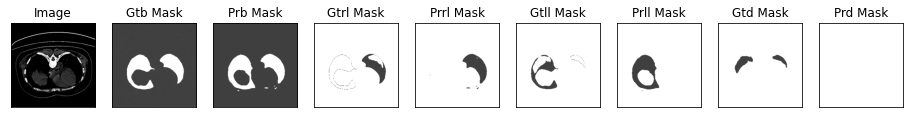

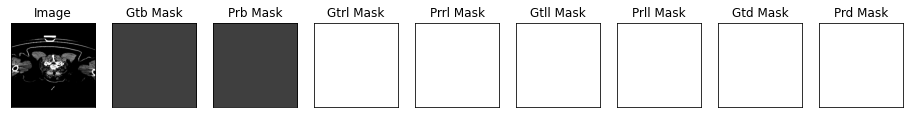

In [ ]:
n = 3
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gtB_mask=gt_mask[..., 0].squeeze(),
        prB_mask=pr_mask[..., 0].squeeze(),
        gtRL_mask=gt_mask[..., 1].squeeze(),
        prRL_mask=pr_mask[..., 1].squeeze(),
        gtLL_mask=gt_mask[..., 2].squeeze(),
        prLL_mask=pr_mask[..., 2].squeeze(),
        gtD_mask=gt_mask[..., 3].squeeze(),
        prD_mask=pr_mask[..., 3].squeeze(),
    )

ROC CURVE

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(K.flatten(test_data_y[..., i]), K.flatten(y_pred[..., i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

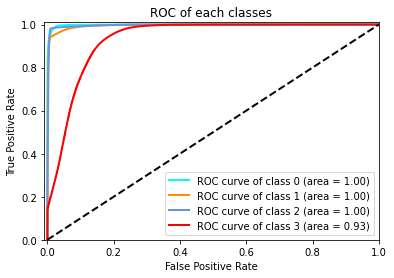

In [ ]:
lw = 2
colors = (['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of each classes')
plt.legend(loc="lower right")
plt.show()

# FPN + inceptionresnetv2

Model Creation

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`


BACKBONE = 'inceptionresnetv2'
BATCH_SIZE = 16
CLASSES = med
LR = 0.0001
EPOCHS = 20

preprocess_input = sm.get_preprocessing(BACKBONE)


# define network parameters
n_classes = 4 # case for binary and multiclass segmentation
activation = 'softmax' 

# #create model
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', input_shape = (256, 256, 3))



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3))
# I personally would chose (None, None, 3) for the input shape
#

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

Error check

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Zenodo MnC/fpn/models/fpn_inceptionresnetv2.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/Zenodo MnC/fpn/csv/fpn_inceptionresnetv2.csv', separator=",", append=True)
]

Training

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=20, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/20
177/177 [==============================] - 688s 4s/step - loss: 0.1531 - iou_score: 0.3482 - f1-score: 0.4201 - val_loss: 0.0422 - val_iou_score: 0.6080 - val_f1-score: 0.6481
Epoch 2/20
177/177 [==============================] - 577s 3s/step - loss: 0.0950 - iou_score: 0.5457 - f1-score: 0.6118 - val_loss: 0.0243 - val_iou_score: 0.6420 - val_f1-score: 0.6817
Epoch 3/20
177/177 [==============================] - 579s 3s/step - loss: 0.0878 - iou_score: 0.5905 - f1-score: 0.6566 - val_loss: 0.0244 - val_iou_score: 0.6605 - val_f1-score: 0.7021
Epoch 4/20
177/177 [==============================] - 579s 3s/step - loss: 0.0800 - iou_score: 0.6292 - f1-score: 0.6934 - val_loss: 0.0224 - val_iou_score: 0.6710 - val_f1-score: 0.7169
Epoch 5/20
177/177 [==============================] - 578s 3s/step - loss: 0.0791 - iou_score: 0.6483 - f1-score: 0.7141 - val_loss: 0.0193 - val_iou_score: 0.6787 - val_f1-score: 0.7221
Epoch 6/20
177/177 [==============================] - 577s 3s/ste

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.11279
mean iou_score: 0.62647
mean f1-score: 0.70213


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.024318
mean iou_score: 0.68508
mean f1-score: 0.73059


Graphs

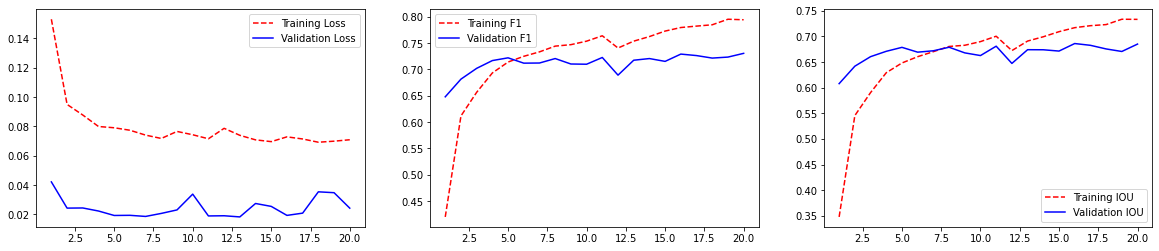

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy4 = history.history['f1-score']
validation_accuracy4 = history.history['val_f1-score']

training_accuracy5 = history.history['iou_score']
validation_accuracy5 = history.history['val_iou_score']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy4, 'r--')
axs[1].plot(epoch_count, validation_accuracy4, 'b-')
axs[1].legend(['Training F1', 'Validation F1'])

axs[2].plot(epoch_count, training_accuracy5, 'r--')
axs[2].plot(epoch_count, validation_accuracy5, 'b-')
axs[2].legend(['Training IOU', 'Validation IOU'])

Testing

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=med, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=16, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('/content/drive/MyDrive/Zenodo MnC/fpn/models/fpn_inceptionresnetv2.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.021255
mean iou_score: 0.69138
mean f1-score: 0.7578


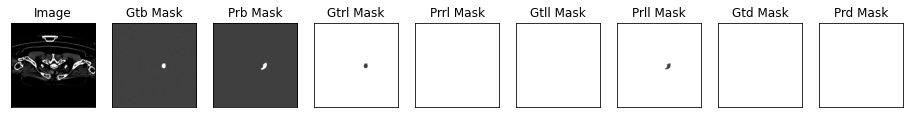

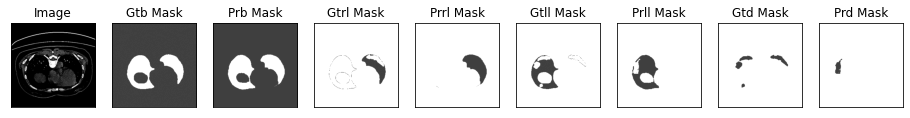

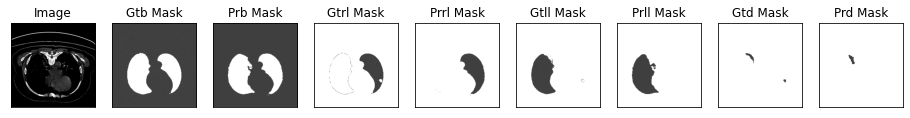

In [ ]:
n = 3
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gtB_mask=gt_mask[..., 0].squeeze(),
        prB_mask=pr_mask[..., 0].squeeze(),
        gtRL_mask=gt_mask[..., 1].squeeze(),
        prRL_mask=pr_mask[..., 1].squeeze(),
        gtLL_mask=gt_mask[..., 2].squeeze(),
        prLL_mask=pr_mask[..., 2].squeeze(),
        gtD_mask=gt_mask[..., 3].squeeze(),
        prD_mask=pr_mask[..., 3].squeeze(),
    )

ROC CURVE

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(K.flatten(test_data_y[..., i]), K.flatten(y_pred[..., i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

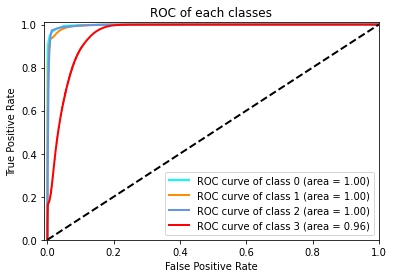

In [ ]:
lw = 2
colors = (['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of each classes')
plt.legend(loc="lower right")
plt.show()

# FPN + mobilenetv2

Model Creation

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`


BACKBONE = 'mobilenetv2'
BATCH_SIZE = 16
CLASSES = med
LR = 0.0001
EPOCHS = 20

preprocess_input = sm.get_preprocessing(BACKBONE)


# define network parameters
n_classes = 4 # case for binary and multiclass segmentation
activation = 'softmax' 

# #create model
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', input_shape = (256, 256, 3))



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3))
# I personally would chose (None, None, 3) for the input shape
#

/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

Error check

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/fpn remaining/fpn_mobilenetv2.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/fpn remaining/fpn_mobilenetv2.csv', separator=",", append=True)
]

Training

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=20, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/20
177/177 [==============================] - 339s 2s/step - loss: 0.1765 - iou_score: 0.2936 - f1-score: 0.3610 - val_loss: 0.0932 - val_iou_score: 0.4352 - val_f1-score: 0.4659
Epoch 2/20
177/177 [==============================] - 302s 2s/step - loss: 0.1166 - iou_score: 0.4294 - f1-score: 0.5088 - val_loss: 0.0957 - val_iou_score: 0.4657 - val_f1-score: 0.5025
Epoch 3/20
177/177 [==============================] - 302s 2s/step - loss: 0.0970 - iou_score: 0.5236 - f1-score: 0.6014 - val_loss: 0.0806 - val_iou_score: 0.5016 - val_f1-score: 0.5409
Epoch 4/20
177/177 [==============================] - 302s 2s/step - loss: 0.0907 - iou_score: 0.5674 - f1-score: 0.6421 - val_loss: 0.0739 - val_iou_score: 0.5130 - val_f1-score: 0.5559
Epoch 5/20
177/177 [==============================] - 301s 2s/step - loss: 0.0870 - iou_score: 0.5941 - f1-score: 0.6660 - val_loss: 0.0496 - val_iou_score: 0.5613 - val_f1-score: 0.6066
Epoch 6/20
177/177 [==============================] - 301s 2s/ste

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.074077
mean iou_score: 0.59686
mean f1-score: 0.66721


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.024688
mean iou_score: 0.65707
mean f1-score: 0.70299


Graphs

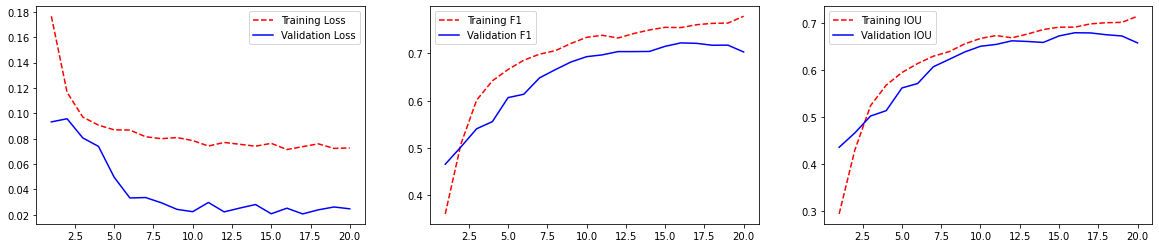

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy4 = history.history['f1-score']
validation_accuracy4 = history.history['val_f1-score']

training_accuracy5 = history.history['iou_score']
validation_accuracy5 = history.history['val_iou_score']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy4, 'r--')
axs[1].plot(epoch_count, validation_accuracy4, 'b-')
axs[1].legend(['Training F1', 'Validation F1'])

axs[2].plot(epoch_count, training_accuracy5, 'r--')
axs[2].plot(epoch_count, validation_accuracy5, 'b-')
axs[2].legend(['Training IOU', 'Validation IOU'])

Testing

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=med, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=16, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('/content/drive/MyDrive/Z Segmentation/Unet/Models/UnetEB00.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.020827
mean iou_score: 0.62277
mean f1-score: 0.68568


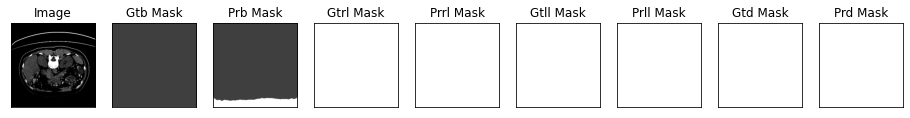

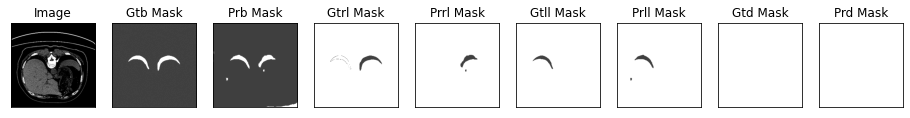

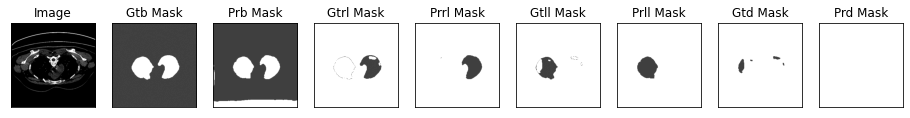

In [ ]:
n = 3
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gtB_mask=gt_mask[..., 0].squeeze(),
        prB_mask=pr_mask[..., 0].squeeze(),
        gtRL_mask=gt_mask[..., 1].squeeze(),
        prRL_mask=pr_mask[..., 1].squeeze(),
        gtLL_mask=gt_mask[..., 2].squeeze(),
        prLL_mask=pr_mask[..., 2].squeeze(),
        gtD_mask=gt_mask[..., 3].squeeze(),
        prD_mask=pr_mask[..., 3].squeeze(),
    )

ROC CURVE

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(K.flatten(test_data_y[..., i]), K.flatten(y_pred[..., i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

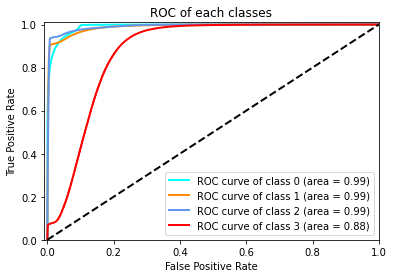

In [ ]:
lw = 2
colors = (['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of each classes')
plt.legend(loc="lower right")
plt.show()

# FPN + densenet121

Model Creation

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`


BACKBONE = 'densenet121'
BATCH_SIZE = 16
CLASSES = med
LR = 0.0001
EPOCHS = 15

preprocess_input = sm.get_preprocessing(BACKBONE)


# define network parameters
n_classes = 4 # case for binary and multiclass segmentation
activation = 'softmax' 

# #create model
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', input_shape = (256, 256, 3))



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3))
# I personally would chose (None, None, 3) for the input shape
#

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_36 (ZeroPadding2 (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_36[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

Error check

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/zfpn rem/fpn_densenet121.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/zfpn rem/fpn_densenet121.csv', separator=",", append=True)
]

Training

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=15, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/15
177/177 [==============================] - 517s 3s/step - loss: 0.1651 - iou_score: 0.3276 - f1-score: 0.3988 - val_loss: 0.0433 - val_iou_score: 0.5277 - val_f1-score: 0.5702
Epoch 2/15
177/177 [==============================] - 453s 3s/step - loss: 0.1053 - iou_score: 0.4849 - f1-score: 0.5583 - val_loss: 0.0379 - val_iou_score: 0.6210 - val_f1-score: 0.6683
Epoch 3/15
177/177 [==============================] - 453s 3s/step - loss: 0.0914 - iou_score: 0.5629 - f1-score: 0.6311 - val_loss: 0.0233 - val_iou_score: 0.6043 - val_f1-score: 0.6415
Epoch 4/15
177/177 [==============================] - 453s 3s/step - loss: 0.0873 - iou_score: 0.5920 - f1-score: 0.6597 - val_loss: 0.0299 - val_iou_score: 0.6341 - val_f1-score: 0.6827
Epoch 5/15
177/177 [==============================] - 452s 3s/step - loss: 0.0827 - iou_score: 0.6197 - f1-score: 0.6865 - val_loss: 0.0266 - val_iou_score: 0.6811 - val_f1-score: 0.7276
Epoch 6/15
177/177 [==============================] - 451s 3s/ste

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.049544
mean iou_score: 0.66477
mean f1-score: 0.74081


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.021062
mean iou_score: 0.72145
mean f1-score: 0.76848


Graphs

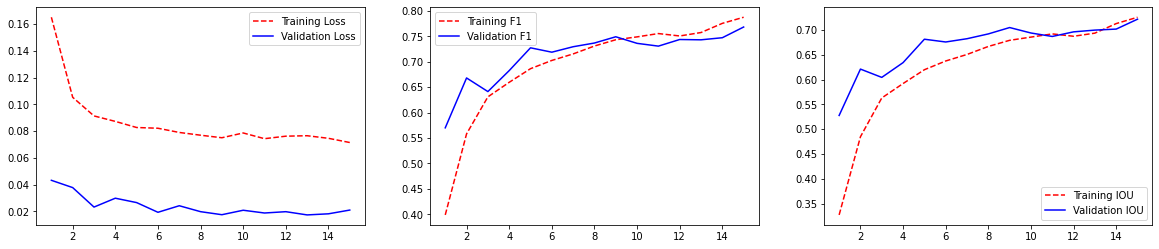

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy4 = history.history['f1-score']
validation_accuracy4 = history.history['val_f1-score']

training_accuracy5 = history.history['iou_score']
validation_accuracy5 = history.history['val_iou_score']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy4, 'r--')
axs[1].plot(epoch_count, validation_accuracy4, 'b-')
axs[1].legend(['Training F1', 'Validation F1'])

axs[2].plot(epoch_count, training_accuracy5, 'r--')
axs[2].plot(epoch_count, validation_accuracy5, 'b-')
axs[2].legend(['Training IOU', 'Validation IOU'])

Testing

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=med, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=16, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('/content/drive/MyDrive/Z Segmentation/Unet/Models/UnetEB00.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.0196
mean iou_score: 0.70341
mean f1-score: 0.76923


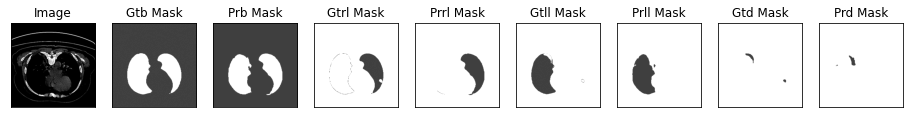

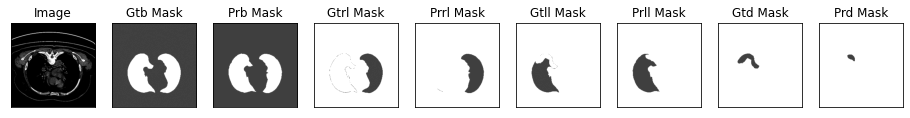

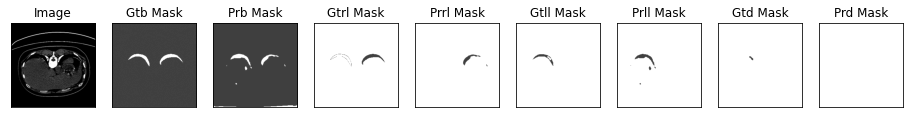

In [ ]:
n = 3
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gtB_mask=gt_mask[..., 0].squeeze(),
        prB_mask=pr_mask[..., 0].squeeze(),
        gtRL_mask=gt_mask[..., 1].squeeze(),
        prRL_mask=pr_mask[..., 1].squeeze(),
        gtLL_mask=gt_mask[..., 2].squeeze(),
        prLL_mask=pr_mask[..., 2].squeeze(),
        gtD_mask=gt_mask[..., 3].squeeze(),
        prD_mask=pr_mask[..., 3].squeeze(),
    )

ROC CURVE

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(K.flatten(test_data_y[..., i]), K.flatten(y_pred[..., i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

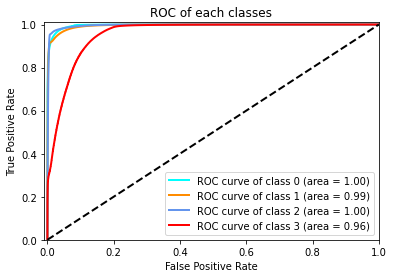

In [ ]:
lw = 2
colors = (['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of each classes')
plt.legend(loc="lower right")
plt.show()

# FPN + seresnet101

Model Creation

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`


BACKBONE = 'seresnet101'
BATCH_SIZE = 16
CLASSES = med
LR = 0.0001
EPOCHS = 15

preprocess_input = sm.get_preprocessing(BACKBONE)


# define network parameters
n_classes = 4 # case for binary and multiclass segmentation
activation = 'softmax' 

# #create model
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', input_shape = (256, 256, 3))



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3))
# I personally would chose (None, None, 3) for the input shape
#

190668800/190663368 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
____________________________________________________________________________________________

Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

Error check

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/zfpn rem/fpn_seresnet101.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/zfpn rem/fpn_seresnet101.csv', separator=",", append=True)
]

Training

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=15, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/15
177/177 [==============================] - 690s 4s/step - loss: 0.1411 - iou_score: 0.3893 - f1-score: 0.4575 - val_loss: 0.0296 - val_iou_score: 0.6008 - val_f1-score: 0.6345
Epoch 2/15
177/177 [==============================] - 580s 3s/step - loss: 0.0950 - iou_score: 0.5474 - f1-score: 0.6144 - val_loss: 0.0185 - val_iou_score: 0.6606 - val_f1-score: 0.6953
Epoch 3/15
177/177 [==============================] - 579s 3s/step - loss: 0.0815 - iou_score: 0.6157 - f1-score: 0.6806 - val_loss: 0.0241 - val_iou_score: 0.6507 - val_f1-score: 0.6920
Epoch 4/15
177/177 [==============================] - 580s 3s/step - loss: 0.0809 - iou_score: 0.6441 - f1-score: 0.7078 - val_loss: 0.0186 - val_iou_score: 0.6483 - val_f1-score: 0.6826
Epoch 5/15
177/177 [==============================] - 579s 3s/step - loss: 0.0776 - iou_score: 0.6521 - f1-score: 0.7181 - val_loss: 0.0203 - val_iou_score: 0.6671 - val_f1-score: 0.7059
Epoch 6/15
177/177 [==============================] - 579s 3s/ste

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.099848
mean iou_score: 0.57855
mean f1-score: 0.65273


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.016913
mean iou_score: 0.67115
mean f1-score: 0.71414


Graphs

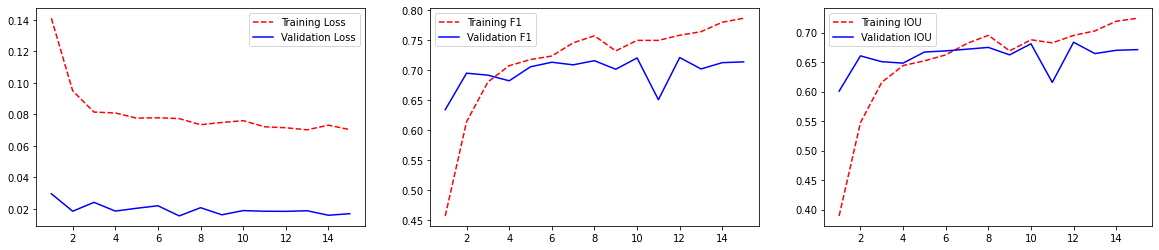

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy4 = history.history['f1-score']
validation_accuracy4 = history.history['val_f1-score']

training_accuracy5 = history.history['iou_score']
validation_accuracy5 = history.history['val_iou_score']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy4, 'r--')
axs[1].plot(epoch_count, validation_accuracy4, 'b-')
axs[1].legend(['Training F1', 'Validation F1'])

axs[2].plot(epoch_count, training_accuracy5, 'r--')
axs[2].plot(epoch_count, validation_accuracy5, 'b-')
axs[2].legend(['Training IOU', 'Validation IOU'])

Testing

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=med, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=16, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('/content/drive/MyDrive/Z Segmentation/Unet/Models/UnetEB00.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.01803
mean iou_score: 0.67889
mean f1-score: 0.7414


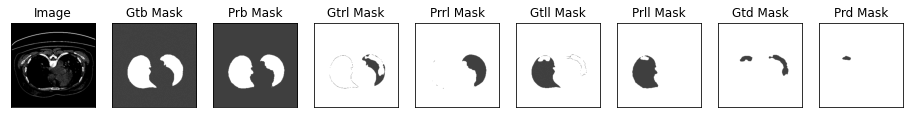

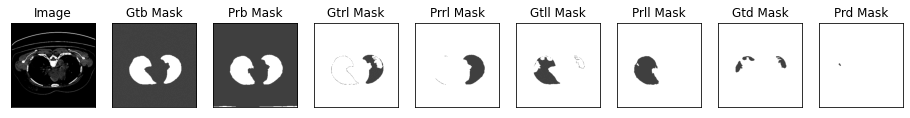

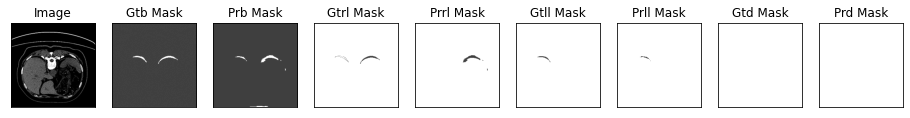

In [ ]:
n = 3
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gtB_mask=gt_mask[..., 0].squeeze(),
        prB_mask=pr_mask[..., 0].squeeze(),
        gtRL_mask=gt_mask[..., 1].squeeze(),
        prRL_mask=pr_mask[..., 1].squeeze(),
        gtLL_mask=gt_mask[..., 2].squeeze(),
        prLL_mask=pr_mask[..., 2].squeeze(),
        gtD_mask=gt_mask[..., 3].squeeze(),
        prD_mask=pr_mask[..., 3].squeeze(),
    )

ROC CURVE

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(K.flatten(test_data_y[..., i]), K.flatten(y_pred[..., i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

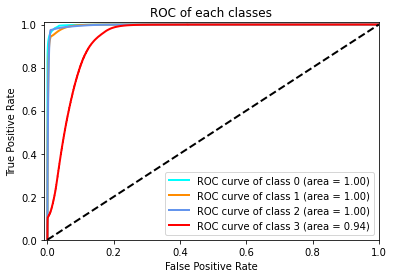

In [ ]:
lw = 2
colors = (['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of each classes')
plt.legend(loc="lower right")
plt.show()